In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

# from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# import shap

pd.set_option('display.max_rows', 250)

In [ ]:
df=pd.read_csv('Dataset.csv')
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [ ]:
df.shape

(91713, 186)

In [ ]:
print("Number of rows with missing values:", df.isnull().any(axis=1).sum())

Number of rows with missing values: 91688


In [ ]:
large_missing = list(df.isna().sum()[df.isna().sum()>25000].index)

print("\nTotal features with more than", 25000, "missing values:", len(large_missing))

df.drop(large_missing + ['encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'], 
              axis=1,
             inplace = True)
df


Total features with more than 25000 missing values: 74


,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


*Removing missing values from some of the inter-related columns (bmi, weight and height)*  
We cut down almost 3000 instances with this process safely

In [ ]:
df = df[df[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
df

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,0,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


### Univariate-Multivariate Analysis

Individual plots seldom doesn't help in large datasets, in this approach let's look at the variation of instances according to each context of the column


<br> <br> 

The death rate for Male-Female patients is shown below. While the rate of **<span style="color: deeppink;"> female deaths</span>** are **<span style="color: red;"> higher </span>** the youngest person to pass away during one of the case was a **<span style="color: royalblue;">Male</span>** of **16yrs** of age

In [ ]:
fig = px.histogram(df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df[['age','gender','hospital_death','bmi']].columns)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

**<span style="color: midnightblue;">Average hospital death probability of patients</span>**  
*based on age and gender*

In [ ]:
age_death_F=df[df['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=df[df['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Male patients"))
fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

**<span style="color: midnightblue;">impacts of BMI and weight over patients</span>**

In [ ]:
weight_df=df[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>impacts of BMI and weight over patients<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death")
fig.show()

**<span style="color: midnightblue;">Survival rate at different types of ICU</span>**

*some of the ICU wards have higher death probability pertaining to being surgical wards*

In [ ]:
ICU_type=df[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="<b>Survival rate at different types of ICU<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

**<span style="color: midnightblue;">Hospital Death Rate, by age and Medical condition</span>**

In [ ]:
apache3=df[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

# Preprocessing

converting categorical values  
tranforming numerical columns and removing nulls

Null values for *categories* are replaced by **mode**, and those for *numerical* are replaced by **mean**

In [ ]:
split_col=df.isna().sum()[df.isna().sum()<11000].index

In [ ]:
for col in split_col:
  try:
    df[col]=df[col].fillna(df[col].mean())
  except:
    df[col]=df[col].fillna(df[col].mode())

df=df.dropna(axis=0)

In [ ]:
categorical=df.describe(include=['O']).columns

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
import category_encoders as ce
bi_encoder=ce.BinaryEncoder()

df_bi=bi_encoder.fit_transform(df[categorical])
df_bi_fl=pd.concat([df,df_bi],axis=1)
df_bi_fl.shape

(44766, 121)

In [ ]:
df_bi_fl=df_bi_fl.drop(categorical,axis=1)
df_bi_fl.shape

(44766, 116)

In [ ]:
X=df_bi_fl.drop('hospital_death',axis=1)
y=df_bi_fl['hospital_death']

### Balancing Dataset

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X,y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# creating an instance for MinMaxScaler
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_smt)

In [ ]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report
xTrain,xTest_,yTrain,yTest_=train_test_split(X_train_std,y_smt,test_size=0.4,random_state=42)
xVal,xTest,yVal,yTest=train_test_split(xTest_,yTest_,test_size=0.5,random_state=42)

### Baseline Model

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense,Dropout
from keras.models import Model,Sequential
from keras.optimizers import Adam

In [ ]:
model=Sequential()
model.add(Dense(128,activation='relu',input_shape=(xTrain.shape[-1],)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14848     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
# Compile model
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#early stopping
early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                       patience=7,
                                       mode='min')

In [ ]:
# Train model
history=model.fit(xTrain, yTrain,
          batch_size=64,
          epochs=500,
          callbacks=[early],
          verbose=1,
          validation_data=(xVal, yVal))

Epoch 1/500
766/766 [==============================] - 7s 5ms/step - loss: 0.5762 - accuracy: 0.6885 - val_loss: 0.3969 - val_accuracy: 0.8295
Epoch 2/500
766/766 [==============================] - 3s 4ms/step - loss: 0.4154 - accuracy: 0.8181 - val_loss: 0.3338 - val_accuracy: 0.8562
Epoch 3/500
766/766 [==============================] - 3s 3ms/step - loss: 0.3653 - accuracy: 0.8449 - val_loss: 0.3013 - val_accuracy: 0.8703
Epoch 4/500
766/766 [==============================] - 3s 3ms/step - loss: 0.3409 - accuracy: 0.8530 - val_loss: 0.2879 - val_accuracy: 0.8748
Epoch 5/500
766/766 [==============================] - 3s 4ms/step - loss: 0.3243 - accuracy: 0.8602 - val_loss: 0.2757 - val_accuracy: 0.8814
Epoch 6/500
766/766 [==============================] - 3s 4ms/step - loss: 0.3098 - accuracy: 0.8652 - val_loss: 0.2703 - val_accuracy: 0.8820
Epoch 7/500
766/766 [==============================] - 3s 4ms/step - loss: 0.3030 - accuracy: 0.8681 - val_loss: 0.2623 - val_accuracy: 0.8861

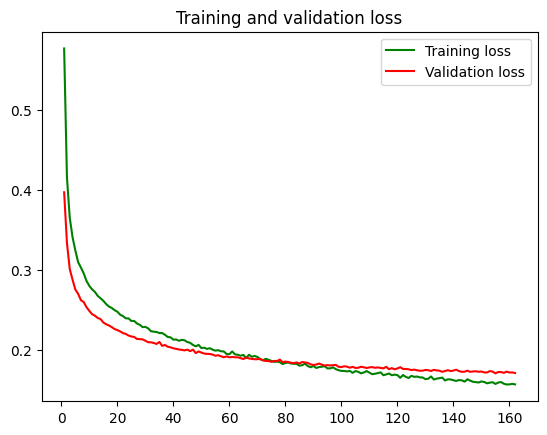

In [ ]:
# Plot results
import matplotlib.pyplot as plt


# acc = history.history['accuracy']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# plt.plot(epochs, acc, 'g', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred=model.predict(xTest)
for i in range(len(pred)):
  if pred[i]>=0.5:
    pred[i]=1
  else:
    pred[i]=0

511/511 [==============================] - 2s 3ms/step


In [ ]:
print(classification_report(yTest,pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      8173
           1       0.94      0.92      0.93      8153

    accuracy                           0.93     16326
   macro avg       0.93      0.93      0.93     16326
weighted avg       0.93      0.93      0.93     16326



In [ ]:
confusion_matrix(yTest,pred)

array([[7686,  487],
       [ 615, 7538]])

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shap

In [ ]:
xTest.shape

(16326, 115)

In [ ]:
sample_set=[]
randomRows = np.random.randint(xTest.shape[0], size=100)
for i in randomRows:
    sample_set.append(list(xTest[i, :]))
sample_set=pd.DataFrame(sample_set)

In [ ]:
explainer = shap.KernelExplainer(model.predict,sample_set)

4/4 [==============================] - 0s 3ms/step


In [ ]:
shap_values = explainer.shap_values(sample_set.values)

  0%|          | 0/100 [00:00<?, ?it/s]

7113/7113 [==============================] - 11s 2ms/step


In [ ]:
shap_values[0].shape

(100, 115)

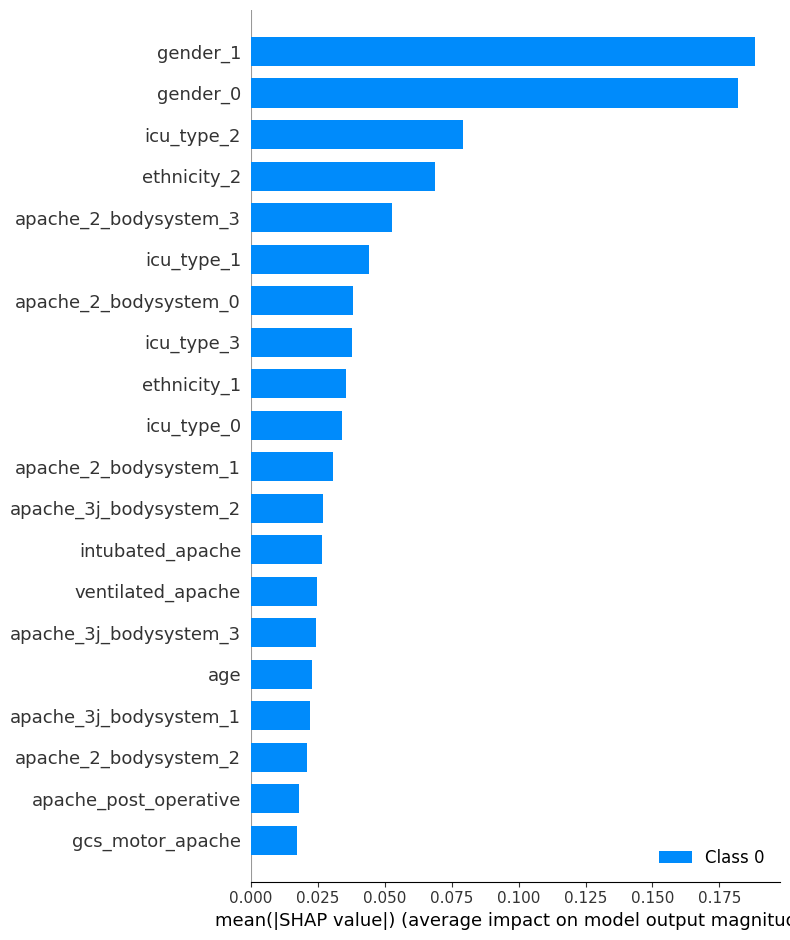

In [ ]:
shap.summary_plot(shap_values,xTest,feature_names=list(X_smt.columns))

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0,:]  ,xTest[0,:],feature_names=list(X_smt.columns))

4/4 [==============================] - 0s 3ms/step


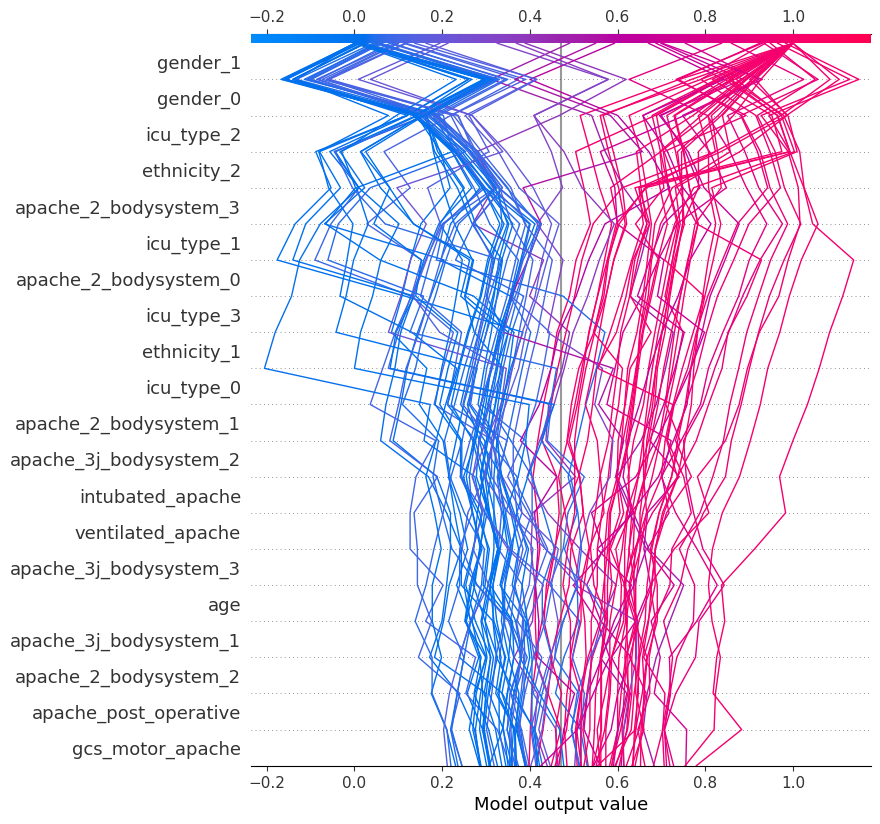

In [ ]:
shap.decision_plot(shap.KernelExplainer(model.predict,sample_set).expected_value[0], shap_values[0], X_smt.columns)

In [ ]:
y[y==1]

In [ ]:
testX=X.iloc[24:26,:]
testY=y.iloc[24:26]

In [ ]:
testX

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# creating an instance for MinMaxScaler
scaler = MinMaxScaler()
test_X = scaler.fit_transform(testX)

In [ ]:
pred_test=model.predict(test_X)
for i in range(len(pred_test)):
  if pred_test[i]>=0.5:
    pred_test[i]=1
  else:
    pred_test[i]=0

In [ ]:
pred_test.shape

In [ ]:
testY

In [ ]:
pred_test

In [ ]:
print(classification_report(testY,pred_test))

I do resampling for data balance but don't get good result for test data